In [188]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk
import re
nltk.download('stopwords', quiet=True)

True

# 1. Exploración de datos 

In [189]:
df_data = pd.read_excel(r"Datos_proyecto.xlsx")
df_data.head()

,textos,labels
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,Para los niños más pequeños (bebés y niños peq...,4
2,"Además, la formación de especialistas en medic...",3
3,En los países de la OCDE se tiende a pasar de ...,4
4,Este grupo se centró en las personas que padec...,3


## 1.1 Calidad de datos

### 1.1.1 Completitud

Se observa que no hay valores nulos en el dataset, hay 2424 filas y 2 columnas, y para cada columna ha 2424 valores no nulos. La columna `textos` es de tipo objeto (string) y la columna `labels` es de tipo entero (int64).

In [190]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   object
 1   labels  2424 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.0+ KB


In [191]:
df_data.columns

Index(['textos', 'labels'], dtype='object')

In [192]:
df_data.count()

textos    2424
labels    2424
dtype: int64

In [193]:
#Valores nulos por columna
print("Datos Nulos")
print(df_data.isnull().sum())

Datos Nulos
textos    0
labels    0
dtype: int64


In [194]:
#Eliminar filas sin texto o etiqueta
df = df_data.dropna(subset=["textos", "labels"])
df.count()

textos    2424
labels    2424
dtype: int64

In [195]:
# verificar si hay textos con strings vacíos
num_empty = (df['textos'].str.strip() == '').sum()
print('Número de textos vacíos:', num_empty)

Número de textos vacíos: 0


### 1.1.2 Unicidad

Se obsera que no hay duplicados en el dataset.

In [196]:
duplicados = df.duplicated(subset = ["textos"])
print(f"Duplicados encontrados: {duplicados.sum()}")

Duplicados encontrados: 0


In [197]:
# 6. Eliminar duplicados exactos (mismo texto y misma etiqueta)
df = df.drop_duplicates(subset=["textos", "labels"])
df.count()

textos    2424
labels    2424
dtype: int64

### 1.1.3 Validez

Revisar que todas las opiniones estén en el mismo idioma (español) y que las etiquetas sean del conjunto {1, 3, 4}.

In [198]:
# se demora alrededor de 20 segundos

from langdetect import detect

def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"

df["language"] = df["textos"].apply(detect_language)

print(len(df[df['language'] != 'es']))

0


In [199]:
# clases en el datset
df['labels'].unique()

array([4, 3, 1])

Todos los textos están en español, no se encontraron textos en otros idiomas.

In [200]:
df = df.drop(columns=['language'])

### 1.1.4 Consistencia

In [201]:
df["word_count"] = df["textos"].apply(lambda x: len(str(x).split()))

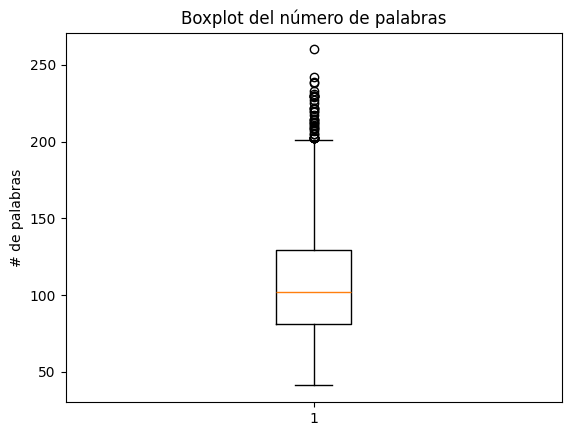

In [202]:
plt.boxplot(df['word_count'])
plt.title("Boxplot del número de palabras")
plt.ylabel("# de palabras")
plt.show()

Se observan outliers en textos que tienen una alta cantidad de palabras.

# 2. Preparación de datos y continuación de la exploración

## 2.1 Tokenización y limpieza de texto 

1. Definir función para limpiar y tokenizar el texto.  
2. Aplicar la función a la columna "textos" y almacenar el resultado en una nueva columna.  
3. Crear un dataframe de palabras tokenizadas para análisis posterior.

In [203]:
wpt = nltk.WordPunctTokenizer()
stop_words = set(nltk.corpus.stopwords.words('spanish'))

def tokenize_text(text):
    #Elimina caracteres especiales y espacios en blanco
    doc = re.sub(r'[^a-zA-Z\s]', "", text, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    #Tokenizar documento
    tokens = wpt.tokenize(doc)
    #Filtrar palabras
    filtered_tokens = [token for token in tokens if token not in stop_words]
    #Recrear documento de texto
    doc = ' '.join(filtered_tokens)
    return doc, filtered_tokens

normalized_df = df.copy()
normalized_df[['cleaned_text', 'tokens_list']] = normalized_df["textos"].apply(
    lambda x: pd.Series(tokenize_text(x))
)

# recalcular word_count
normalized_df["word_count"] = normalized_df["textos"].apply(lambda x: len(str(x).split()))

In [204]:
normalized_df.head()

,textos,labels,word_count,cleaned_text,tokens_list
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4,48,aprendizaje educacin consideran sinnimos escol...,"[aprendizaje, educacin, consideran, sinnimos, ..."
1,Para los niños más pequeños (bebés y niños peq...,4,72,nios ms pequeos bebs nios pequeos capacitacin ...,"[nios, ms, pequeos, bebs, nios, pequeos, capac..."
2,"Además, la formación de especialistas en medic...",3,93,adems formacin especialistas medicina general ...,"[adems, formacin, especialistas, medicina, gen..."
3,En los países de la OCDE se tiende a pasar de ...,4,109,pases ocde tiende pasar cursos obligatorios op...,"[pases, ocde, tiende, pasar, cursos, obligator..."
4,Este grupo se centró en las personas que padec...,3,94,grupo centr personas padecen trastornos mental...,"[grupo, centr, personas, padecen, trastornos, ..."


## 2.2 Exploración de distribución de datos

### 2.2.1 Análisis de balance de clases

In [205]:
# 9. Distribución de etiquetas
print("Distribución de clases:")
dist_df = pd.DataFrame({"cantidad": df["labels"].value_counts(), "porcentaje": round(df["labels"].value_counts() / len(df), 2)})
print(dist_df)

Distribución de clases:
        cantidad  porcentaje
labels                      
4           1025        0.42
3            894        0.37
1            505        0.21


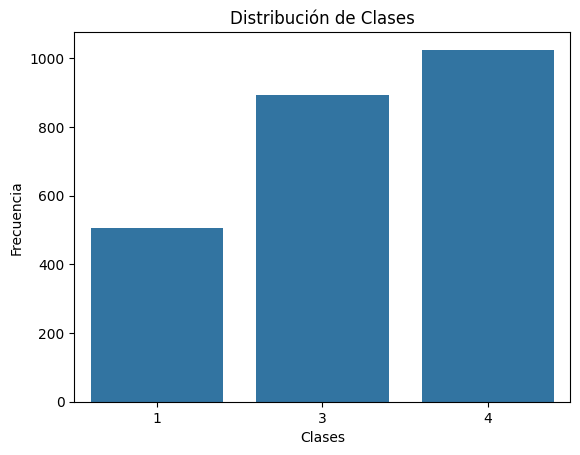

In [206]:
sns.barplot(x=df["labels"].value_counts().index, y=df["labels"].value_counts().values)
plt.title("Distribución de Clases")
plt.xlabel("Clases")
plt.ylabel("Frecuencia")
plt.show()

Las clases 4 y 3 tienen una mayor representación en el dataset, mientras que las clases 1 tiene una representación menor.

### 2.2.2 Análisis de la distribución del número de palabras por clase

Se verifica que la diferencia entre las medias de la longitud de los textos de cada clase no sea significativa con una prueba *ANOVA*.

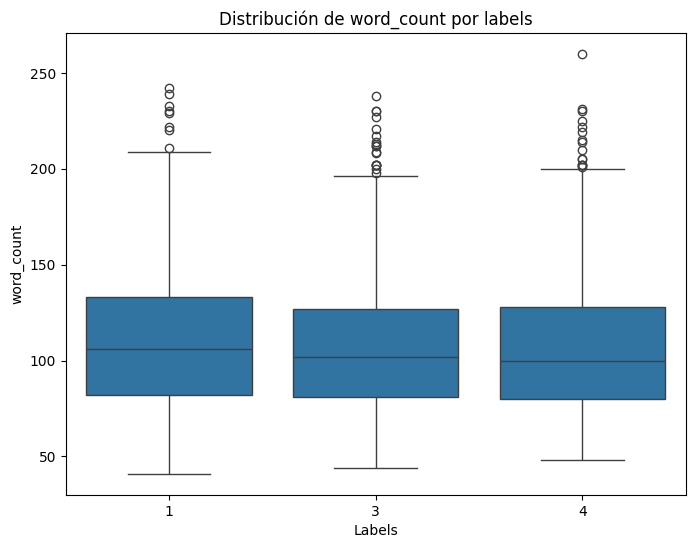

In [207]:
plt.figure(figsize=(8,6))
sns.boxplot(x='labels', y='word_count', data=df)

plt.title("Distribución de word_count por labels")
plt.xlabel("Labels")
plt.ylabel("word_count")
plt.show()

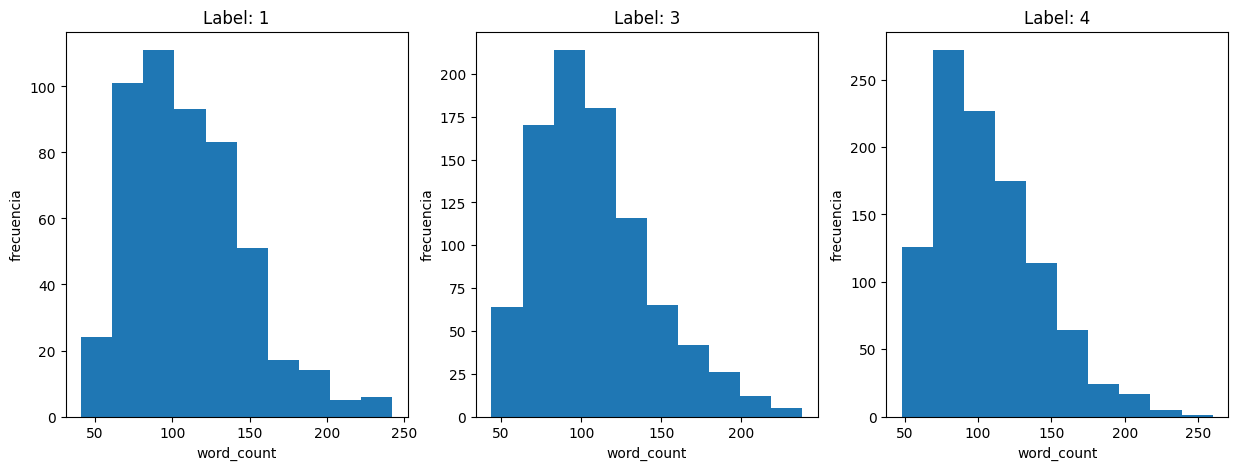

In [210]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))

for i, label in enumerate(sorted(df['labels'].unique())):
    ax[i].hist(df[df['labels'] == label]['word_count'])
    ax[i].set_xlabel("word_count")
    ax[i].set_ylabel("frecuencia")
    ax[i].set_title(f"Label: {label}")
    
    
plt.show()

Hipótesis Nula ($H_0$): No hay diferencia en la media de la variable numérica `word_count` para todos los grupos: $ \mu_1 = \mu_3 = \mu_4 $.

Hipótesis Alterna ($H_1$): Hay una diferencia en la media de la variable numérica `word_count` para al menos uno de los grupos: $ \mu_i \neq \mu_j $ para al menos un par $(i, j)$, donde $i, j \in \{1, 3, 4\}$ y $i \neq j$.

In [ ]:
from scipy.stats import f_oneway

label1_group = normalized_df[normalized_df['labels'] == 1]['word_count']
label3_group = normalized_df[normalized_df['labels'] == 3]['word_count']
label4_group = normalized_df[normalized_df['labels'] == 4]['word_count']

f_statistic, p_value = f_oneway(label1_group, label3_group, label4_group)

print("Resultados del Test ANOVA:")
print("="*30)
print(f"Estadístico F: {f_statistic:.4f}")
print(f"P-value: {p_value:.4f}")
print("="*30)

alpha = 0.05

print("Interpretación:")
if p_value < alpha:
    print(f"p-value ({p_value:.4f}) es menor que {alpha}.")
    print("Se rechaza la hipótesis nula (H0).")
    print("Conclusión: Existe una diferencia estadísticamente significativa en la media de 'word_count' de al menos uno de los grupos.")
else:
    print(f"p-value ({p_value:.4f}) es mayor que {alpha}.")
    print("No se puede rechazar la hipótesis nula (H0).")
    print("Conclusión: No hay evidencia suficiente para afirmar que las medias de 'word_count' son diferentes entre los grupos.")

Resultados del Test ANOVA:
Estadístico F: 1.8812
P-value: 0.1526
Interpretación:
P-value (0.1526) es mayor que 0.05.
No podemos rechazar la hipótesis nula (H₀).
Conclusión: No hay evidencia suficiente para afirmar que las medias del 'word_count' son diferentes entre los grupos.

=> Este resultado apoya tu objetivo de mostrar que las medias no son significativamente diferentes.


Dado el resultado de la prueba *ANOVA* de una vía con $\alpha = 0.05$, no se puede rechazar la hipótesis nula, lo que indica que no hay evidencia suficiente para afirmar que existen diferencias significativas en la media de la variable `word_count` entre las diferentes clases.

De este modo, se tiene claridad en que la longitud de los textos no introduce un sesgo significativo en el análisis de las opiniones clasificadas en las diferentes clases.

### 2.2.3 Distribución del número de palabras en todo el dataset

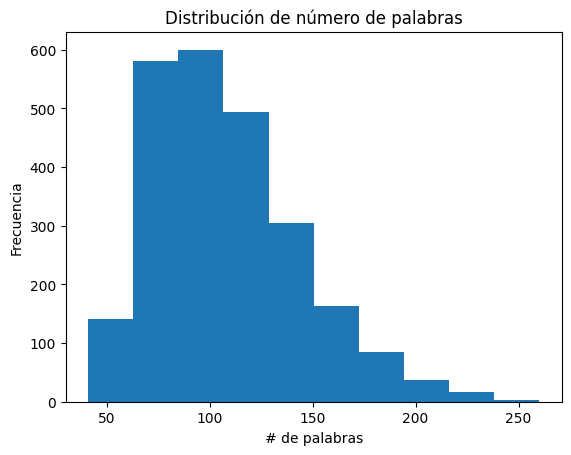

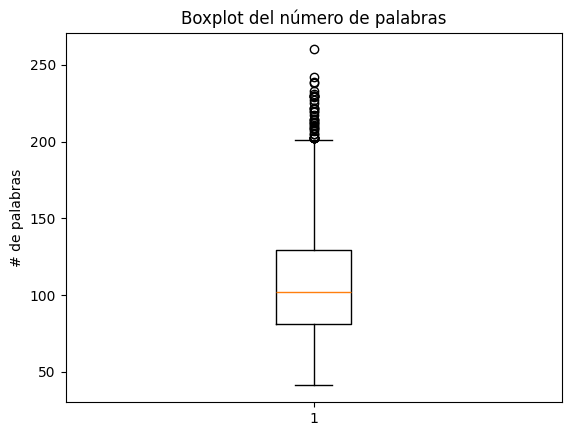

In [209]:
plt.hist(normalized_df['word_count'])
plt.title("Distribución de número de palabras")
plt.xlabel("# de palabras")
plt.ylabel("Frecuencia")
plt.show()

plt.boxplot(normalized_df['word_count'])
plt.title("Boxplot del número de palabras")
plt.ylabel("# de palabras")
plt.show()

## 2.3 Exploración de las palabras más frecuentes y representativas por clase